Group:

1. Jonathan Arias Rua 
2. Isaac Alejandro Blanco Amador
3. Enrique Jose Miranda Rebolledo

Subject: A* Search

# Problem

The objective of this evaluation is to design and implement an A* Search algorithm using Python (Uninorte´s Google Colab) for solving a 2x2 Rubik’s Cube.

The initial state must be generated by applying 10 random steps to a fixed cube.

The fixed cube faces positions must be set as indicated in Figure 1.

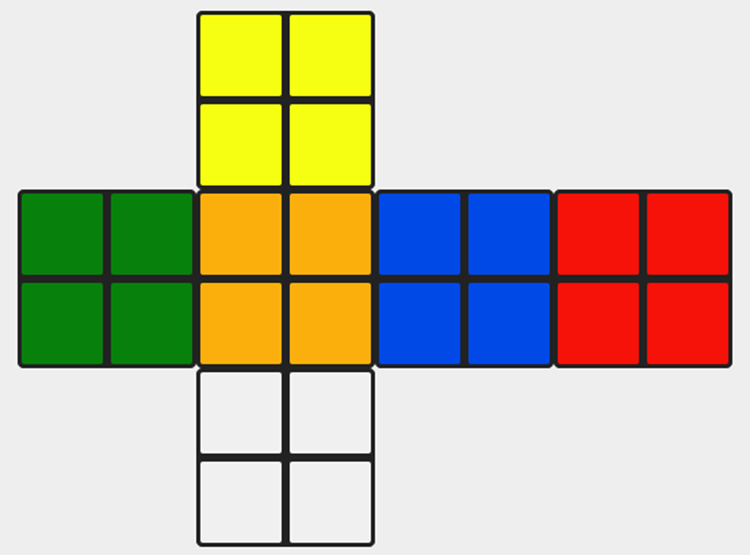

In order to indicate each movement, use the colors of the faces in figure 1 and the direction, i.e.: red-left, yellow-right, etc.

The states, heuristics, and accumulated distances generated after each iteration must be printed out into a text file.

The steps to be applied to fix the cube must be printed out at the bottom of the solution text file.


# Development

We are going to use the following notation to name the faces of the rubik cube

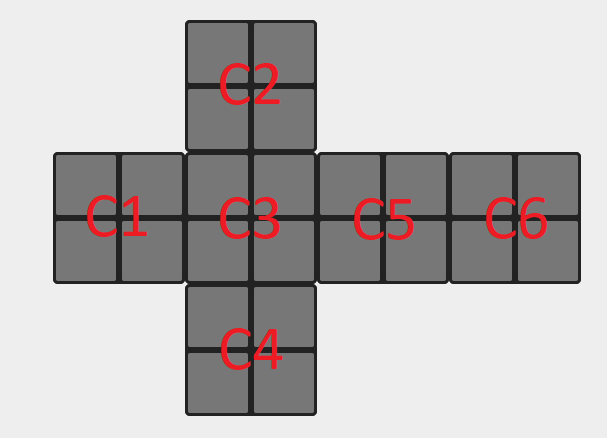

Also, the movements are only two in function of a face:
1. Left, equals 3 right turns 
2. Right

For example, this is the movement (C1,R)

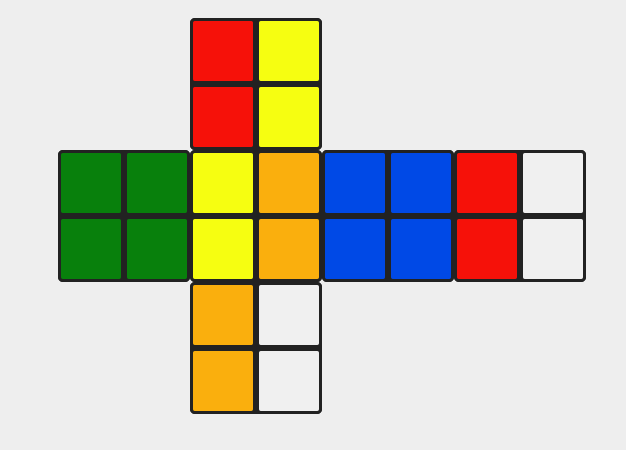

For example, this is the movement (C4,L)

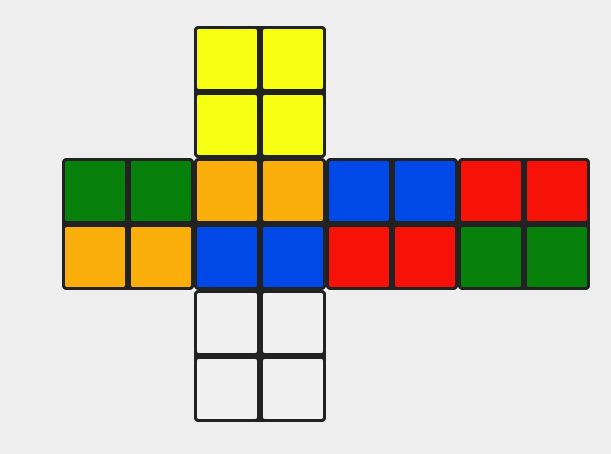

## Data Structure and movements

In [1]:
import numpy as np
from typing import List, Tuple

In [2]:
import sys
import heapq

In [3]:
# ROTATE RIGHT OFFSET
def ror(number : int, displacement :int, size : int = 16) -> int:
  # Mask to obtain the last "displacement" number of bits  
  last_bits = number & int('0b' + ('1' * displacement),2)
  # Shift right "displacement" number to get rid off that
  number = number >> displacement
  # Add "size-displacement" zeros 
  last_bits = last_bits << (size - displacement)
  return last_bits | number

In [4]:
# ROTATE LEFT OFFSET
def rol(number : int, displacement: int, size : int = 16) -> int:
  # Mask to obtain the first "displacement" number of bits  
  mask = int('0b' + ('1' * displacement),2) << (size-displacement)
  first_bits = number & mask
  # Shift left "displacement" number to get rid off that
  number = ( number & (~mask) ) << displacement
  # Add "size-displacement" zeros 
  first_bits = first_bits >> (size - displacement)
  return first_bits | number

In [5]:
def binary_to_nibbles(binario):
    # Convertir el binario a un string de bits y completarlo con ceros a la izquierda hasta que la longitud sea un múltiplo de 16
    binario_str = format(binario, '016b')
    # Dividir el binario en nibbles y guardarlos en una lista
    nibbles = [int(binario_str[i:i+4], 2) for i in range(0, len(binario_str), 4)]
    return nibbles

In [6]:
def get_mask_by_number(value: int,number: int) -> int:
  return value >> ( ( 3 - number ) * 4) & 0b1111

In [57]:
def print_state(cube : int) -> str:
  """ Print in console the state of each face"""
  str_cube = ""
  for (face, state) in cube.items():
    items = binary_to_nibbles(cube[face])
    str_cube += f"FACE {face}\n{colors[items[0]]} {colors[items[1]]}\n{colors[items[3]]} {colors[items[2]]}\n"
  return str_cube

In [8]:
def replace_in_mask(face: int, value: int, id: int) -> int:
  mask = 0b1111 << ( 3 - id  ) * 4
  face = face & ~mask
  value = value << (3 - id ) * 4
  return value | face

In [9]:
def reset_cube():
  """ Reset the cube to the perfect state """
  return {
    "C1": 0b0000000000000000,
    "C2": 0b0001000100010001,
    "C3": 0b0010001000100010,
    "C4": 0b0011001100110011,
    "C5": 0b0100010001000100,
    "C6": 0b0101010101010101,
  }

In [10]:
def clone_cube(cubik_to_paste):
  return {
    "C1": cubik_to_paste['C1'],
    "C2": cubik_to_paste['C2'],
    "C3": cubik_to_paste['C3'],
    "C4": cubik_to_paste['C4'],
    "C5": cubik_to_paste['C5'],
    "C6": cubik_to_paste['C6'],
  }

In [11]:
def movement(cube: dict, face : str , orientation: str) -> None:
  """ Make the move to all layers adjacent to the given face with the orientation"""
  copy = clone_cube(cube)
  adjacents =  relation[face]
  join_mask = 0b0
  copy[face] = rol(copy[face], 4) if orientation == "l" else ror(copy[face],4) 
  for (face, [i,j]) in adjacents.items():
    current = copy[face]
    nibble1, nibble2 = get_mask_by_number(current,i), get_mask_by_number(current,j)
    join_mask = (join_mask << 4 | nibble1) << 4 | nibble2
  state = rol(join_mask, 8, 32) if orientation == "l" else ror(join_mask,8,32)
  for (face, [i,j]) in list(adjacents.items())[::-1]:
    last_value = get_mask_by_number(state, 3)
    state = state >> 4
    last_value_2 = get_mask_by_number(state,3)
    state = state >> 4
    temp = replace_in_mask(copy[face], last_value, j)
    temp = replace_in_mask(temp, last_value_2, i)
    copy[face] = temp
  return copy

In [12]:
# Colors representation
colors = {
    0b0000: "G",
    0b0001: "Y",
    0b0010: "O",
    0b0011: "W",
    0b0100: "B",
    0b0101: "R",
}

In [13]:
# Layers of the rubiks cube
capa_1 = 0b0000000000000000 # Green
capa_2 = 0b0001000100010001 # Yellow
capa_3 = 0b0010001000100010 # Orange
capa_4 = 0b0011001100110011 # White
capa_5 = 0b0100010001000100 # Blue
capa_6 = 0b0101010101010101 # Red

In [32]:
# List of movement restrictions
relation = {
    "C1" : {
      "C2" : [0,3],
      "C3" : [0,3],
      "C4" : [0,3],
      "C6" : [2,1],
    },
    "C2": {
      "C6" : [1,0],
      "C5" : [1,0],
      "C3" : [1,0],
      "C1" : [1,0],
    },
    "C3": {
      "C2" : [3,2],
      "C5" : [0,3],
      "C4" : [1,0],
      "C1" : [2,1],
    },
    "C4": {
      "C3": [3,2],
      "C5": [3,2],
      "C6": [3,2],
      "C1": [3,2],
    },
    "C5": {
      "C2": [2,1],
      "C6": [0,3],
      "C4": [2,1],
      "C3": [2,1],
    },
    "C6": {
      "C2": [1,0],
      "C1": [0,3],
      "C4": [3,2],
      "C5": [2,1]
    }
}

## Simulation to make random movements

In [16]:
movements = ('l','r')

In [17]:
faces = [ "C" + str(i) for i in range(1,7)]

In [63]:
# Type the random seed
np.random.seed(123321)

In [64]:
def generate_random_movements(number_of_steps: int = 10) -> List[Tuple[str, str]]:
  res = []
  for i in range(number_of_steps):
    mov = np.random.choice(movements)
    face = np.random.choice(faces)
    res.append((face,mov))
  return res

In [65]:
def initialize_cube():
  cube = reset_cube()
  moves = generate_random_movements()
  for (face, orientation) in moves:
    print(f'Movement with {face} around {orientation}')
    cube = movement(cube,face,orientation)
  print("")
  print(f"Initial state of the cube \n{print_state(cube)}")
  return cube

## A* Search

In [23]:
def different_nibbles(num):
    binary = '{0:016b}'.format(num)
    distict_nibble = set() 
    for i in range(0, 16, 4):  
        nibble = binary[i:i+4]  
        distict_nibble.add(nibble)  
    return len(distict_nibble) if len(distict_nibble) > 1 else 0 

In [24]:
def equal_nibbles(num: int) -> bool:
    binary = '{0:016b}'.format(num)
    first_nibble = binary[0:4]  
    for i in range(4, 16, 4):  
        if binary[i:i+4] != first_nibble:  
            return False
    return True  

In [25]:
def h1(cube):
  return different_nibbles(cube['C1']) + different_nibbles(cube['C2']) 
  + different_nibbles(cube['C3']) + different_nibbles(cube['C4']) 
  + different_nibbles(cube['C5']) + different_nibbles(cube['C6'])


In [26]:
def check_complete(cube):
  return (equal_nibbles(cube['C1']) and equal_nibbles(cube['C2']) and equal_nibbles(cube['C3']) 
          and equal_nibbles(cube['C4']) and equal_nibbles(cube['C5']) and equal_nibbles(cube['C6']))

In [41]:
def get_possible_states(state: int):
  return [a for a in [(face,direction) for face in state.keys() for direction in ['l','r']]]

In [28]:
def hash_state(state):
    return tuple(sorted(state.items()))

In [87]:
class State:
    id = 0
    def __init__(self,state,movement=None, g=0, h=0, parent=None, move=None, path=''):
      State.id += 1
      self.myID = State.id
      self.state = state
      self.g = g
      self.h = h
      self.parent = parent
      self.movement = movement

    def f(self):
      return self.g + self.h

    def __lt__(self, other):
        return self.f() < other.f()

    def __str__(self):
      return f"state:\n{print_state(self.state)}g: {self.g} | h: {self.h} | f: {self.f()} | movement: {self.movement}"

In [108]:
def a_star(cube: dict):
  execution = []
  # open_list is a list of nodes which have been visited, but not expanded
  # closed_list is a list of nodes which have been visited and expanded
  open_list = [State(state=cube)]
  closed_list = set()

  while open_list:
      current = heapq.heappop(open_list)
      execution.append('Current state \n' + str(current) + "\n")
      if check_complete(current.state):
        return current, execution
      if hash_state(current.state) in closed_list:
          continue
      closed_list.add(hash_state(current.state))
      for poss_state in get_possible_states(current.state):
        temp = movement(current.state,poss_state[0],poss_state[1])
        g = current.g + 1
        h = h1(temp)
        neighbor_state = State(parent=current, state=temp, movement=poss_state, g=g, h=h)
        execution.append(str(neighbor_state))
        heapq.heappush(open_list, neighbor_state)
  return None

In [117]:
cube = initialize_cube()

Movement with C6 around r
Movement with C4 around r
Movement with C5 around r
Movement with C1 around r
Movement with C5 around l
Movement with C4 around l
Movement with C2 around l
Movement with C4 around r
Movement with C6 around l
Movement with C5 around r

Initial state of the cube 
FACE C1
Y G
W G
FACE C2
R Y
W G
FACE C3
R W
Y O
FACE C4
O B
O W
FACE C5
O B
Y B
FACE C6
R G
R B



In [118]:
sol, info_txt = a_star(cube)

In [119]:
res = []
curr = sol
if sol is None:
  print("Irresoluble")
else:
  while curr:
    res.append(curr.movement)
    curr = curr.parent
  res= res[::-1][1:]

In [120]:
# Check if is OK 
answ = clone_cube(cube)
for mov in res:
  answ = movement(answ, mov[0],mov[1])
print(print_state(answ))

FACE C1
W W
W W
FACE C2
R R
R R
FACE C3
G G
G G
FACE C4
O O
O O
FACE C5
Y Y
Y Y
FACE C6
B B
B B



In [121]:
with open('movements.txt' , 'w') as fp:
  fp.write('EXECUTION \n')
  for info in info_txt:
    fp.write(info)
  fp.write('\nSTEPS \n')
  for mov in res:
    orientation = 'left' if mov[1] == 'l' else 'right'
    fp.write(f'Move the face {mov[0]} to the {orientation} \n')

# References

B. Botto, “Implementing an optimal Rubik's cube solver using Korf's algorithm,” Medium, 14-Apr-2022. [Online]. Available: https://medium.com/@benjamin.botto/implementing-an-optimal-rubiks-cube-solver-using-korf-s-algorithm-bf750b332cf9. [Accessed: 28-Feb-2023]. 